In [1]:
import numpy as np
from calendar import isleap
import xarray as xr
import dask.array as da
import dask
import rioxarray as rio
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
ny=1800
nx=4320
dtype_m=np.float32 # 4 byte floats for monthly data
fillval_m=-9999.0 # monthly
npts=2295358

In [3]:
# other constants 

# pxv things
pxv_basedir='/work/hpc/datasets/un_fao/gaez_v5/clim/AgERA5/Hist/'
dataset='AgERA5'
experiment='Hist'
pxvsuf='_5m.pxv'
connector='_'
dailytag='365'
sep='/'
pxvdirnames=['prec','srad','tmax','tmin','vapr','wind']
varnames=['Precip','Srad','Tmax-2m','Tmin-2m','Vapr','Wind-10m']

# raster things
maskfile='/work/hpc/datasets/un_fao/gaez_v5/land/ALOSmask5m_fill.rst'
ydimname='y'
xdimname='x'

nmonths=12
yyyy=2020

# First, get the mask

In [4]:
### get the mask from the rst into an array of 2 dims (x,y)
### and check the mask has the same number of data grids as the pxv data

# open the maskfile but don't include antarctica so mask has shape (y:1800,x:4320)
ds=xr.open_dataset(maskfile,engine='rasterio').isel(y=slice(0,ny)).squeeze()
del ds.coords['band']

# clean up some metadata
ds[xdimname]=ds[xdimname].astype(np.float32)
ds[ydimname]=ds[ydimname].astype(np.float32)
mask2D=ds.band_data

# # convert to 0 & 1 mask
mask2D=xr.where(mask2D>0,1,0).astype('int8')

mask1D=mask2D.stack(space=[ydimname,xdimname]) # collapse mask to 1D: 1800*4320 = 7776000 points
inds_data=mask1D==1  # keep track of which points are not masked out

# plot data in monthly pxv files

min/max value of valid data pts: 0.0 4785.29


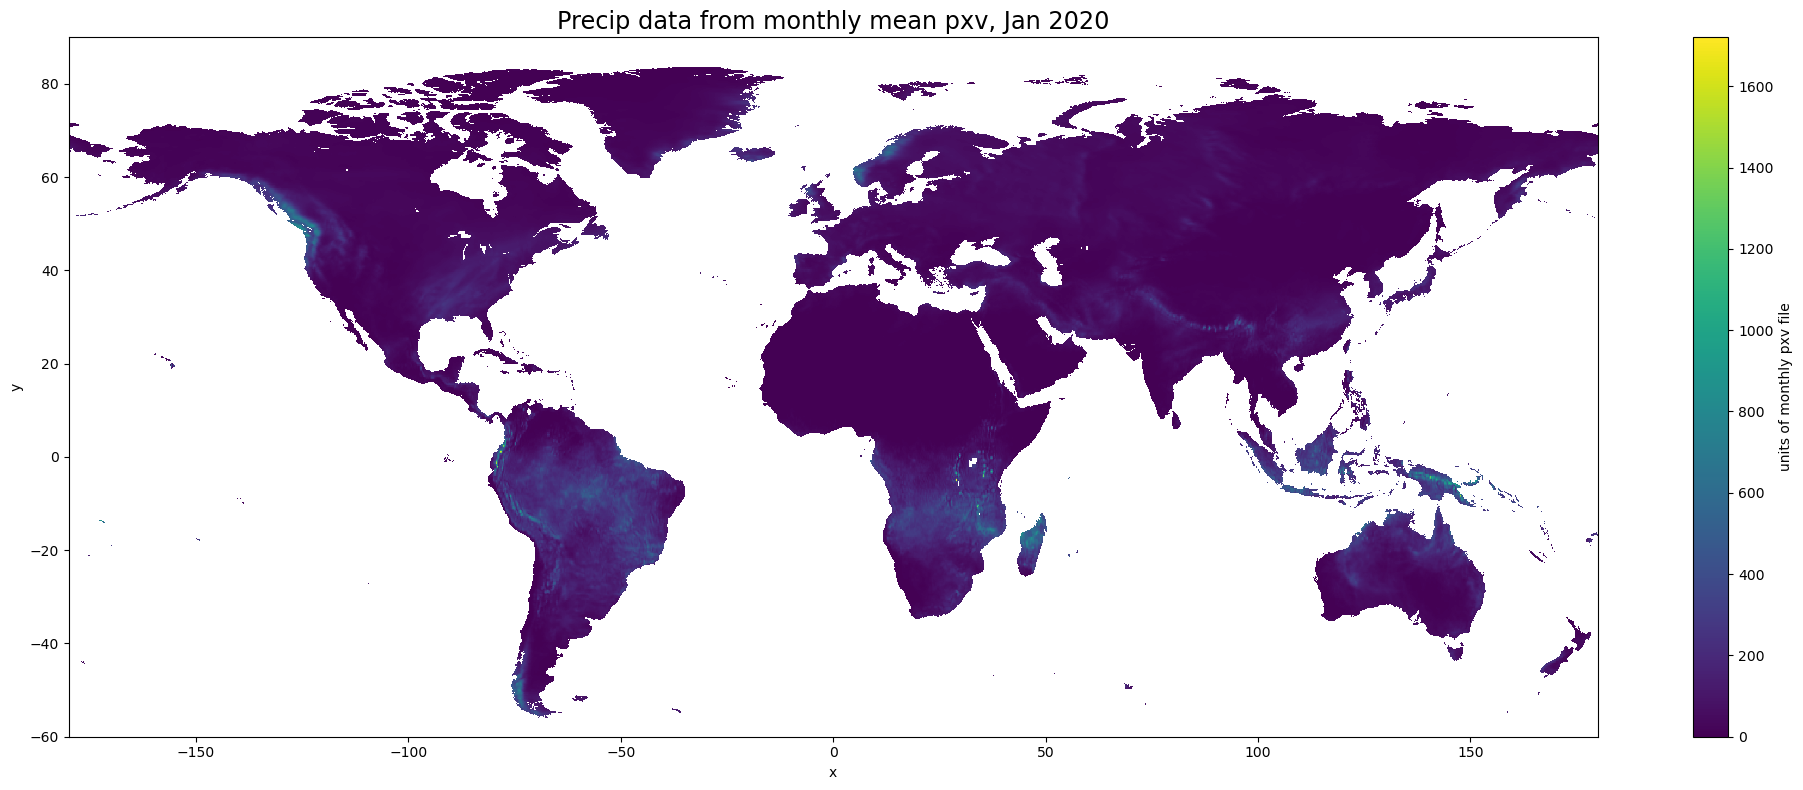

min/max value of valid data pts: 0.0 38049144.0


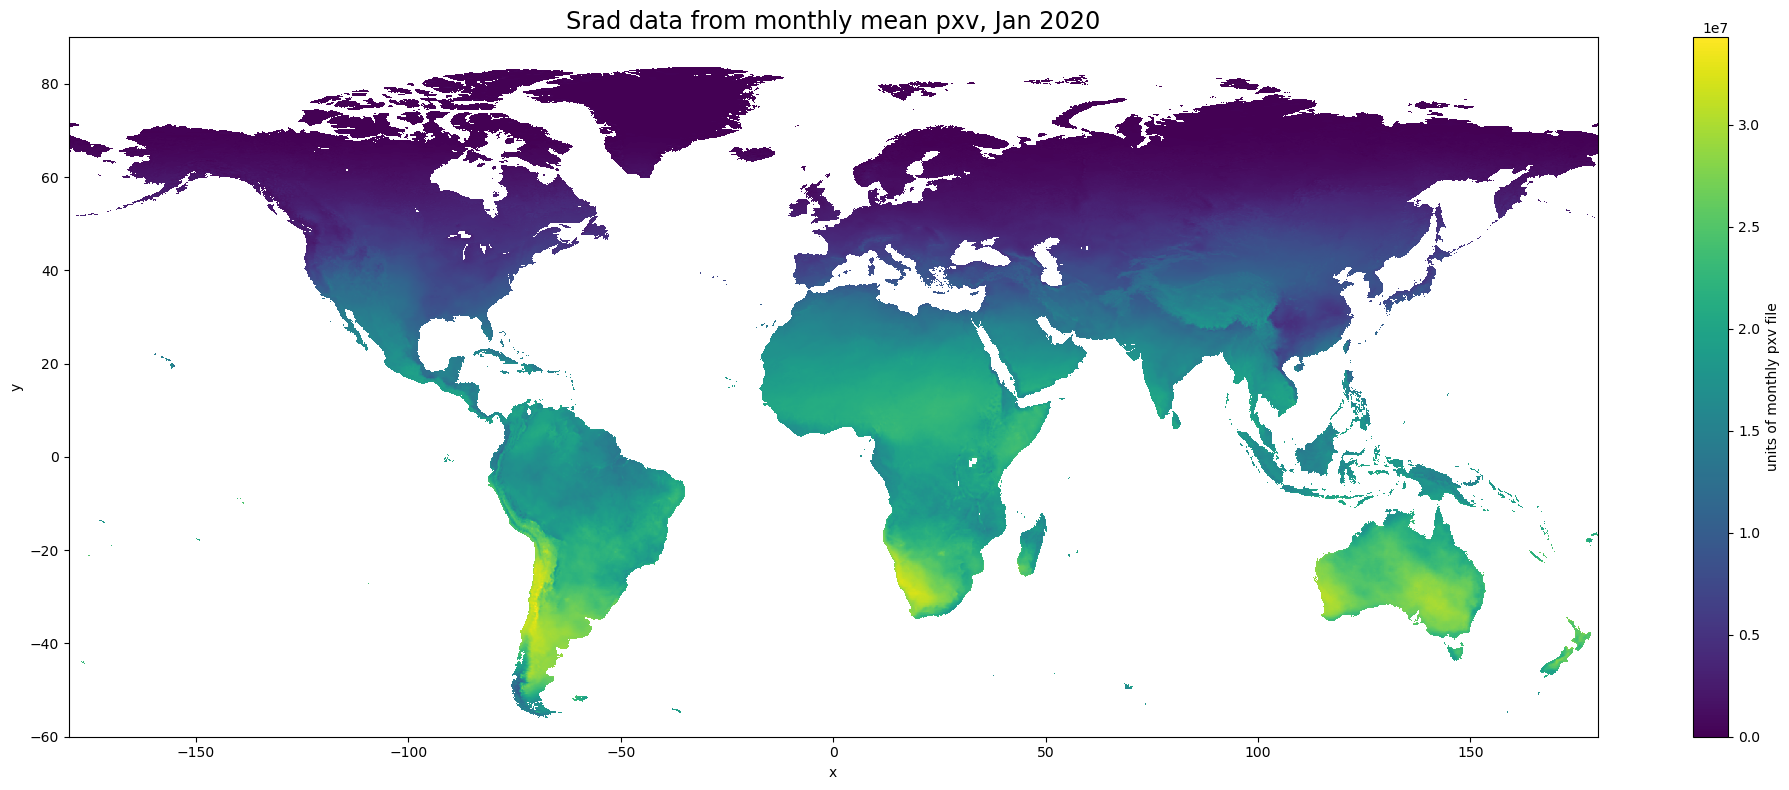

min/max value of valid data pts: -43.57285 48.35532


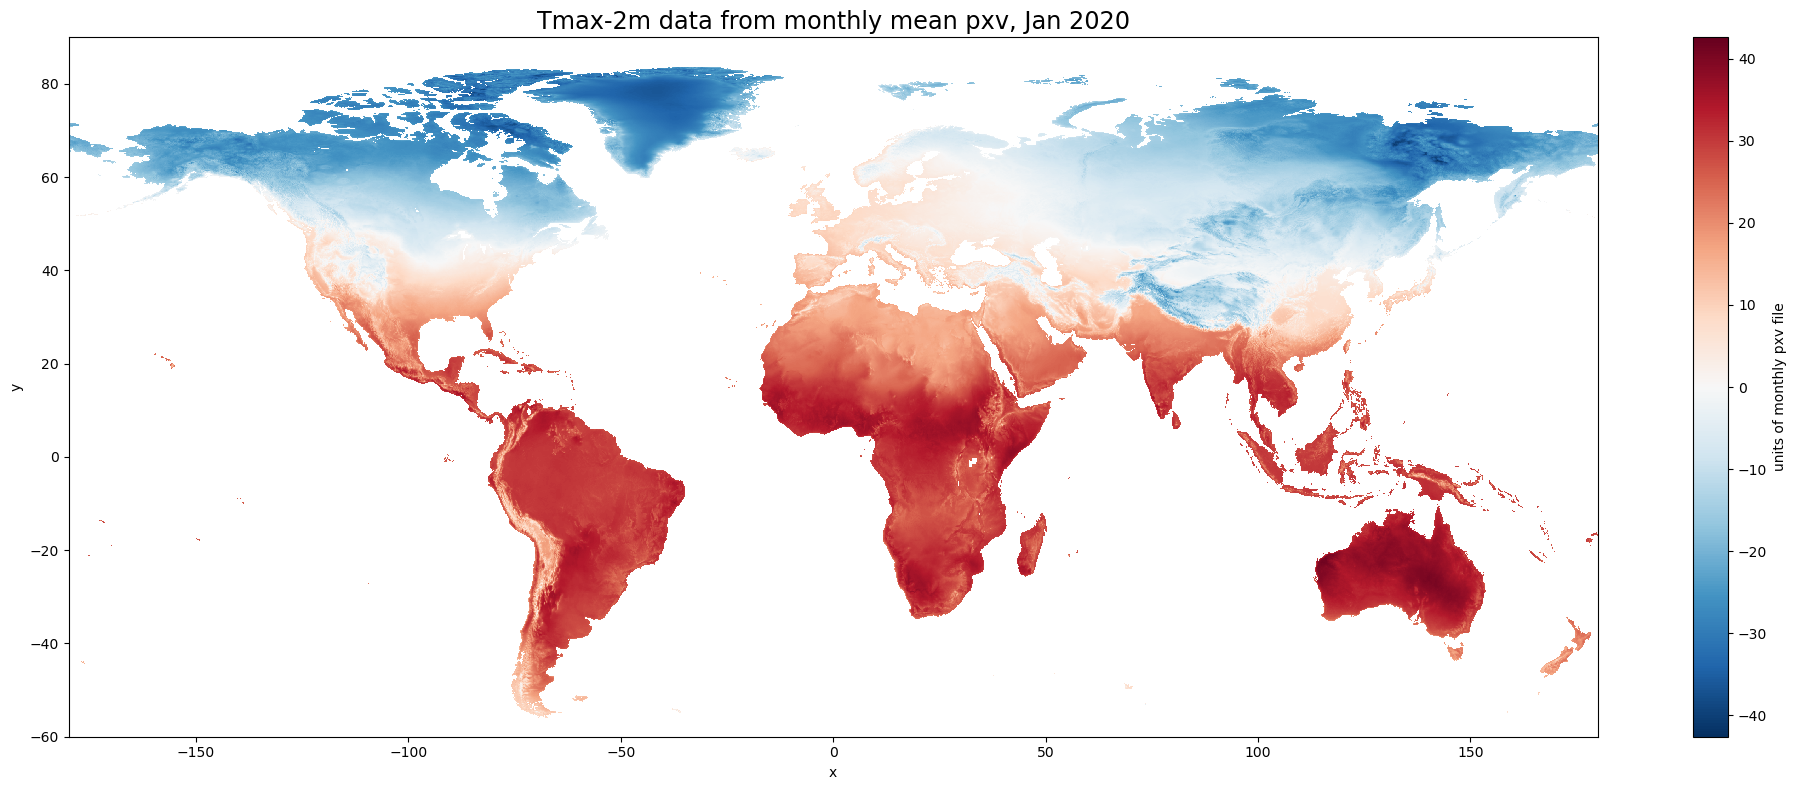

min/max value of valid data pts: -47.66859 34.170994


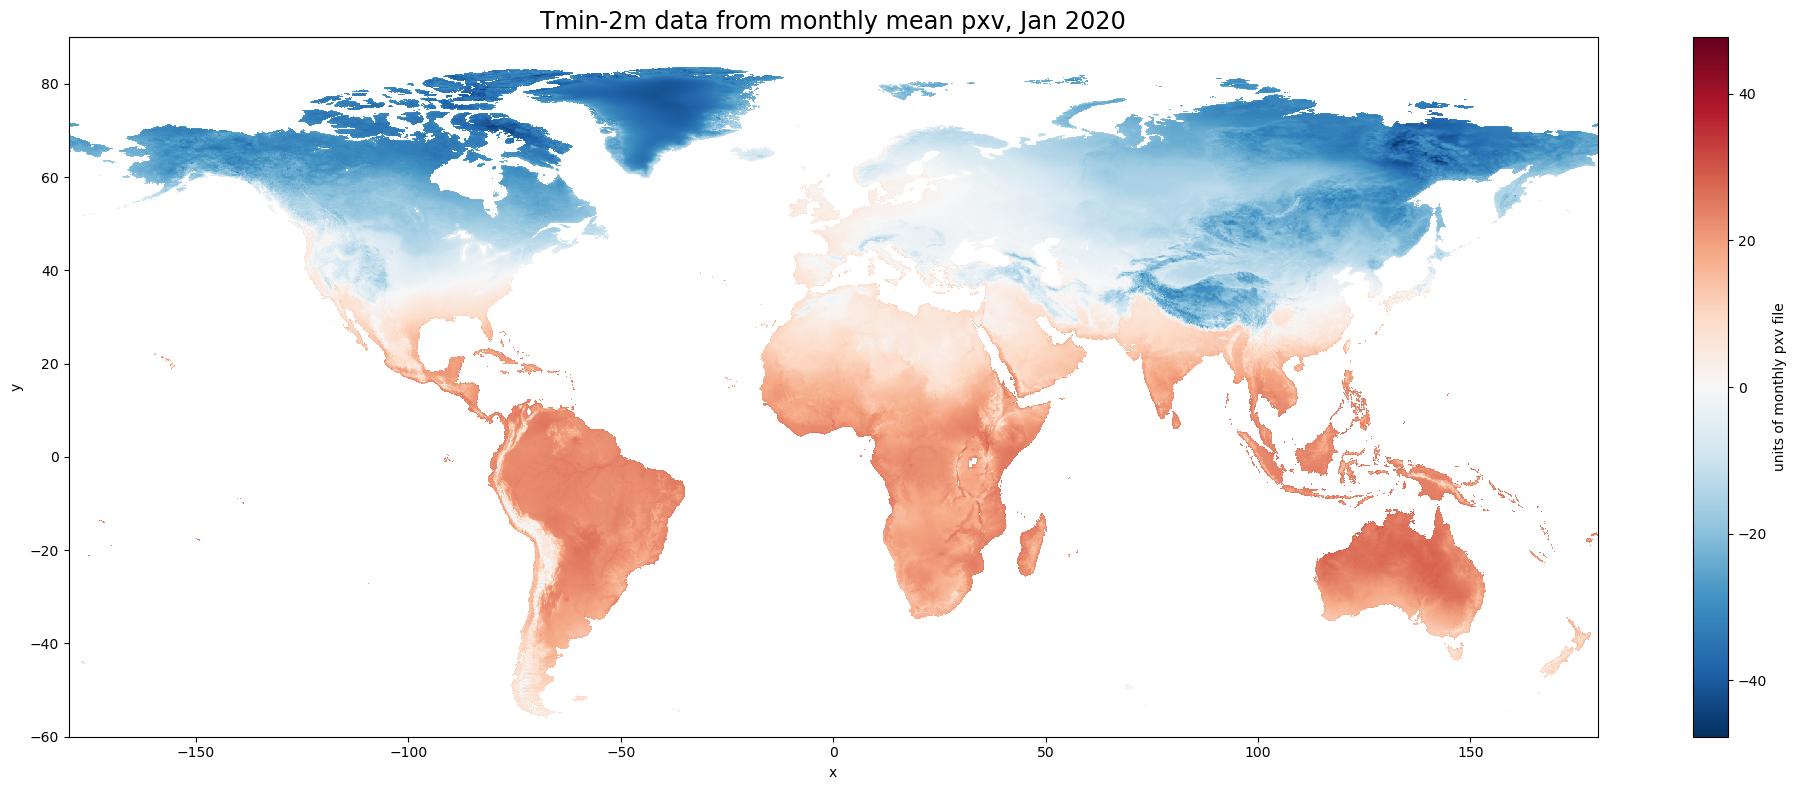

min/max value of valid data pts: 0.025365725 40.53413


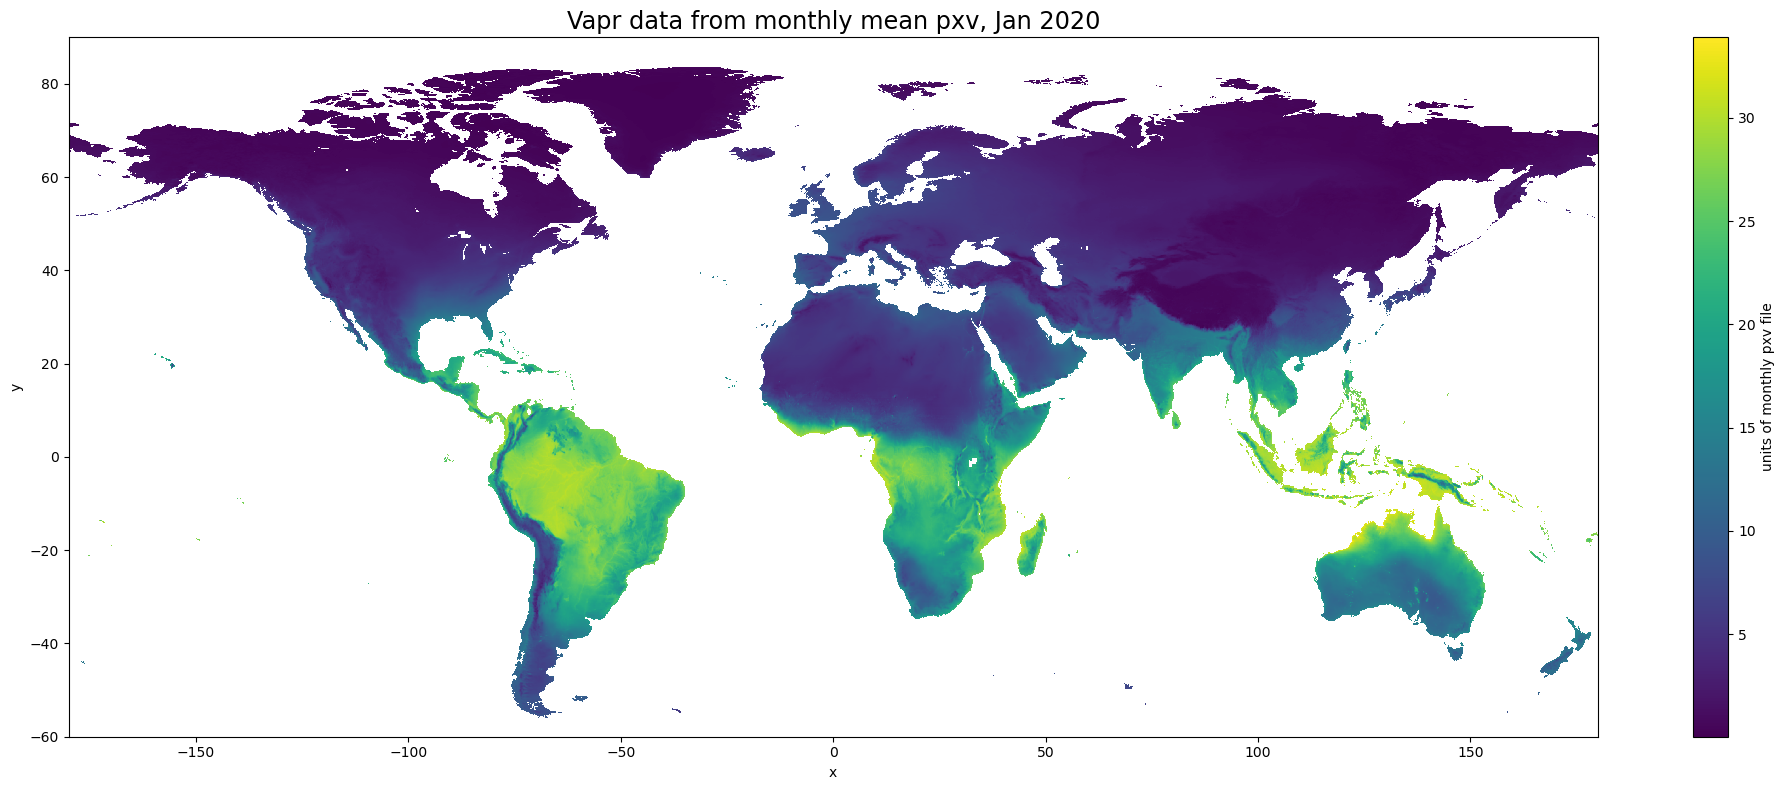

min/max value of valid data pts: 0.18322648 14.127642


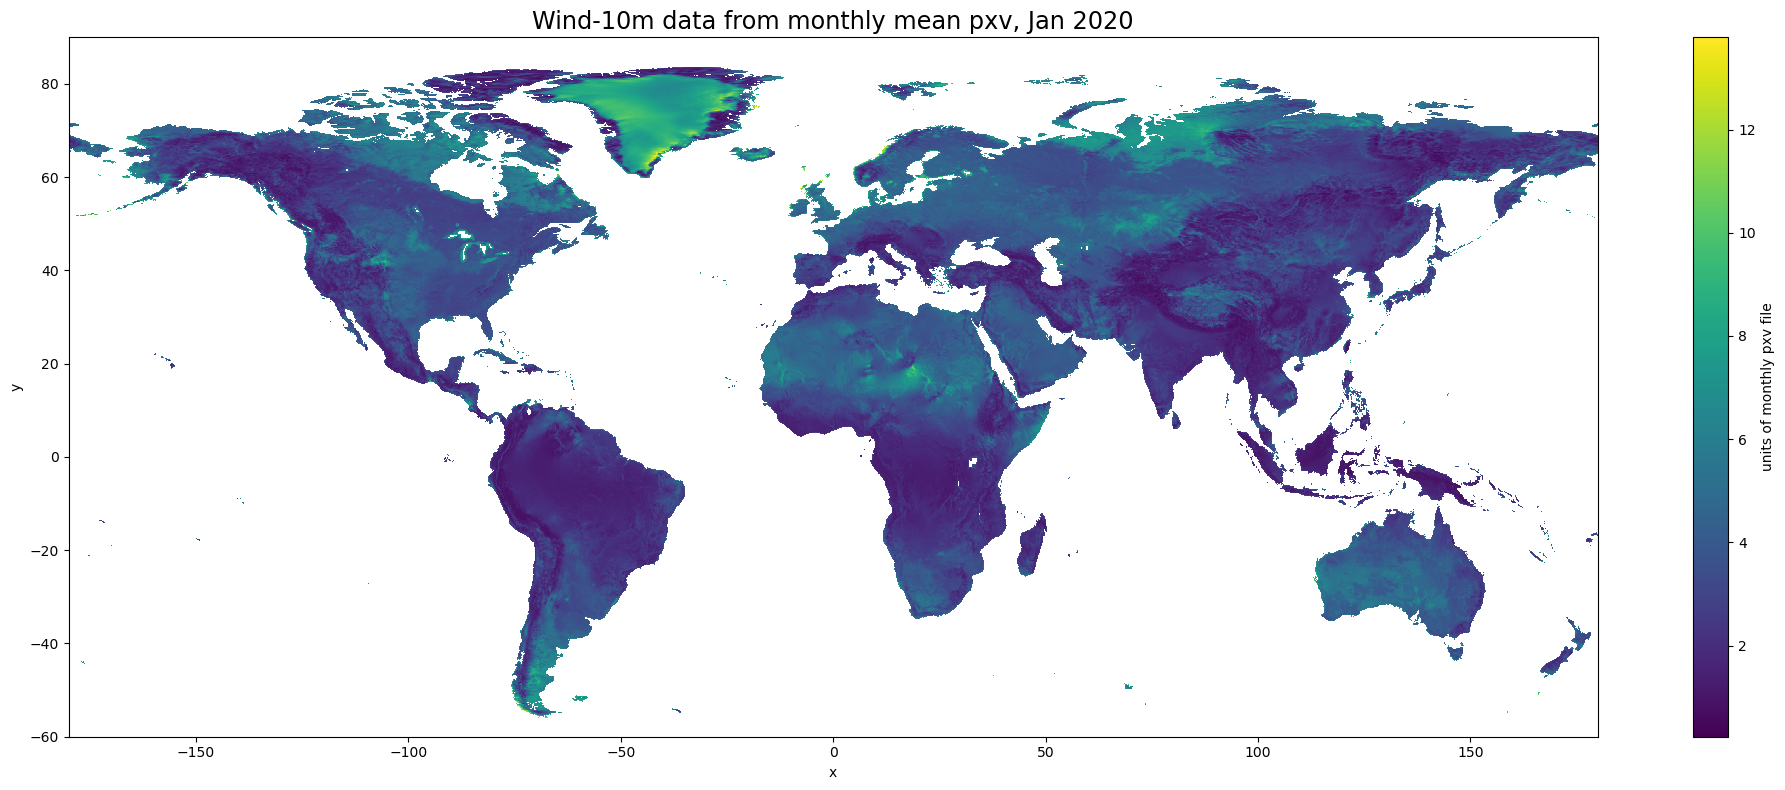

In [5]:
# function to call with dask delayed
def data_to_nd_array(i,inds,arr1D,pxv,arr2D):
    arr1D[inds]=pxv.squeeze()  # remove singleton dim (day)
    arr2D[:,:]=arr1D.unstack() # put 1D data onto the 2D grid
    return arr2D.copy()


for var,pdir in zip(varnames,pxvdirnames):
    pxvfile_m=pxv_basedir+pdir+sep+var+connector+dataset+connector+experiment+connector+str(yyyy)+pxvsuf
    filename=pxvfile_m.split(sep)[-1]

    with open(pxvfile_m,'rb') as f:
        array1D_m=np.fromfile(f,dtype=dtype_m,count=nmonths*npts) # read npts lines of data from file       

    array2D_m=array1D_m.reshape(npts,nmonths) # reshape to 2D

    # print min/max info
    minval=array2D_m.min()
    maxval=array2D_m.max()
    if minval==fillval_m:
        temporary=array2D_m.copy()
        temporary=xr.where(temporary==fillval_m,maxval,temporary)
        minval=temporary.min()
        del temporary
    print('min/max value of valid data pts:',minval,maxval)

    # put data on full global grid

    # set up 
    empty1D_m=mask1D.copy().astype(dtype_m)  # placeholder array for 1D space 
    empty1D_m.rio.write_nodata(fillval_m,inplace=True)
    empty1D_m[:]=fillval_m

    empty2D_m=mask2D.copy().astype(dtype_m)  # placeholder array for 2D grid 
    empty2D_m.rio.write_nodata(fillval_m,inplace=True)
    empty2D_m[:,:]=fillval_m  

    # using dask parallel computing
    pxv_delay=da.from_array(array2D_m,chunks=(-1,1)).to_delayed().ravel()  # create data futures
    task_list=[dask.delayed(data_to_nd_array)(imonth,inds_data,empty1D_m.copy(),pxvdata,empty2D_m.copy()) for imonth,pxvdata in enumerate(pxv_delay)] # lazy tasks
    assert len(task_list)==nmonths, f'{len(task_list)} tasks in list, should be {nmonths}' # double check we've got 1 task per month
    result_chunks_m=dask.compute(*task_list) # execute all computations
    data3D_m=xr.concat(result_chunks_m,dim='time') # concatenate the resulting monthly chunks along a new time dimension
    
    # visual check January
    data3D_m=xr.where(data3D_m==fillval_m,np.nan,data3D_m) # switch fillval to nan  
    data3D_m=data3D_m.rename('units of monthly pxv file')

    figure=plt.figure(figsize=(20,8))
    data3D_m.isel(time=0).plot() # plot January
    plt.title(var+' data from monthly mean pxv, Jan '+str(yyyy),fontsize='xx-large')
    # plt.colorbar(label='units from monthly pvx file')
    plt.tight_layout()
    plt.show()      
    
    del array1D_m,pxvfile_m,filename,minval,maxval,array2D_m,empty1D_m,empty2D_m,pxv_delay,task_list,result_chunks_m,data3D_m,figure